In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


In [2]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [3]:
df = read_csv('cm_all.csv', header=0, index_col=1, squeeze=True)
df = df.drop(df.columns[0],axis=1)
df.head()

,cpu_ghz,cpu_usage,cpu_idle,cpu_total,memory_free_mb,memory_usage,memory_total,cpu_usage_tag,period,weekday
ts,,,,,,,,,,
2017-08-04 07:09:00,1.622994,0.058949,7229.349138,7626.006979,73703.339671,0.171460,85762.997397,0,night,6
2017-08-04 07:10:00,1.565744,0.051145,7436.343501,7808.899014,73678.012357,0.171868,85762.997397,-1,night,6
2017-08-04 07:11:00,1.532764,0.050431,7266.985222,7628.050287,73679.538946,0.171852,85762.997397,-1,night,6
2017-08-04 07:12:00,1.537919,0.055125,7251.151273,7645.735222,73662.632567,0.171941,85762.997397,-1,night,6
2017-08-04 07:13:00,1.535036,0.049197,7272.412151,7618.750821,73644.415185,0.172063,85762.997397,-1,night,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5499 entries, 2017-08-04 07:09:00 to 2017-08-08 02:47:00
Data columns (total 10 columns):
cpu_ghz           5499 non-null float64
cpu_usage         5499 non-null float64
cpu_idle          5499 non-null float64
cpu_total         5499 non-null float64
memory_free_mb    5499 non-null float64
memory_usage      5499 non-null float64
memory_total      5499 non-null float64
cpu_usage_tag     5499 non-null int64
period            5499 non-null object
weekday           5499 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 472.6+ KB


In [4]:
series = df["cpu_usage_tag"]

In [5]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [6]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [36]:
# split data into train and test-sets
train, test = supervised_values[:1200], supervised_values[1200:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [37]:
len(train_scaled)

1200

In [38]:
len(test_scaled)

4298

In [39]:
len(raw_values[1200:])

4299

In [40]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 20, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[1201:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)



1) Test RMSE: 1.007
2) Test RMSE: 0.801
3) Test RMSE: 0.825
4) Test RMSE: 0.752
5) Test RMSE: 0.711
6) Test RMSE: 0.810
7) Test RMSE: 0.717
8) Test RMSE: 0.822
9) Test RMSE: 3.359
10) Test RMSE: 1.030
11) Test RMSE: 0.860
12) Test RMSE: 2.242
13) Test RMSE: 0.720
14) Test RMSE: 0.908
15) Test RMSE: 1.202
16) Test RMSE: 0.827
17) Test RMSE: 0.870
18) Test RMSE: 1.343
19) Test RMSE: 1.023
20) Test RMSE: 1.990
21) Test RMSE: 3.739
22) Test RMSE: 1.609
23) Test RMSE: 0.845
24) Test RMSE: 0.697
25) Test RMSE: 0.758
26) Test RMSE: 0.730
27) Test RMSE: 0.760
28) Test RMSE: 0.796
29) Test RMSE: 0.735
30) Test RMSE: 5.874


            rmse
count  30.000000
mean    1.312019
std     1.142947
min     0.696766
25%     0.758248
50%     0.836227
75%     1.158952
max     5.873849


/home/tu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


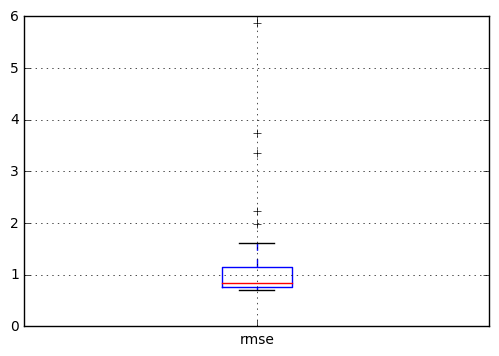

In [41]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()